In [ ]:
from information_extraction import extract_metadata
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from typing import Optional, Tuple
import matplotlib.pyplot as plt

In [ ]:
EARTH_RADIUS_KM = 6371.0088

def haversine_km(a_deg: np.ndarray, b_deg: np.ndarray) -> np.ndarray:
    """a_deg: [2] or [N,2]; b_deg: [M,2] -> pairwise distances (km)."""
    a = np.deg2rad(a_deg)
    b = np.deg2rad(b_deg)
    if a.ndim == 1:
        a = a[None, :]
    dphi = b[:, 0][None, :] - a[:, 0][:, None]
    dlmb = b[:, 1][None, :] - a[:, 1][:, None]
    s = np.sin(dphi/2)**2 + np.cos(a[:, 0])[:, None]*np.cos(b[:, 0])[None, :]*np.sin(dlmb/2)**2
    return 2 * EARTH_RADIUS_KM * np.arcsin(np.sqrt(s))

def pick_two_close_industrial(
    ms_path: str,
    rgb_path: str,
    max_km: float = 5.0,
    min_km: float = 0.0,
    seed: Optional[int] = 42,
) -> Tuple[str, str, float]:
    """
    Returns (id1, id2, distance_km) for two 'Industrial' images within [min_km, max_km].
    Uses the cached pickle via extract_metadata(..., use_cache=True).
    """
    df = extract_metadata(ms_path, rgb_path, use_cache=True)

    # Be strict: exact match to 'Industrial'. If label is slightly different, adjust here.
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)
    if len(dfi) < 2:
        raise ValueError("Industrial class has fewer than two samples.")

    coords = dfi[["latitude", "longitude"]].to_numpy()
    n = len(dfi)
    rng = np.random.default_rng(seed)

    # Try randomized anchors to avoid O(N^2) on big classes
    attempts = min(1000, n * 5)
    for _ in range(attempts):
        i = int(rng.integers(0, n))
        dists = haversine_km(coords[i], coords).flatten()
        # Exclude self; keep band [min_km, max_km]
        mask = (dists >= min_km) & (dists <= max_km)
        mask[i] = False
        idxs = np.where(mask)[0]
        if idxs.size == 0:
            continue
        j = int(rng.choice(idxs))
        # build IDs from filename (since df dropped the original 'id')
        fp_i = dfi.loc[i, "filepath"]
        fp_j = dfi.loc[j, "filepath"]
        id_i = os.path.splitext(os.path.basename(fp_i))[0]
        id_j = os.path.splitext(os.path.basename(fp_j))[0]
        return id_i, id_j, float(dists[j])

    raise RuntimeError(
        f"No Industrial pair found within [{min_km}, {max_km}] km after {attempts} tries. "
        f"Increase max_km or check metadata."
    )

def show_industrial_pair(
    ms_path: str,
    rgb_path: str,
    max_km: float = 5.0,
    min_km: float = 0.0,
    seed: Optional[int] = 42,
    use_tensor_transform=None,   # optional torchvision transform
) -> Tuple[str, str, float]:
    """
    Finds a pair and displays them side-by-side. Returns (id1, id2, distance_km).
    """
    id1, id2, dist_km = pick_two_close_industrial(
        ms_path=ms_path, rgb_path=rgb_path, max_km=max_km, min_km=min_km, seed=seed
    )
    # Rebuild absolute paths
    df = extract_metadata(ms_path, rgb_path, use_cache=True)
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)

    # Map ids back to rows (by filename stem)
    def stem(row):
        return os.path.splitext(os.path.basename(row["filepath"]))[0]

    row1 = dfi[dfi["filepath"].apply(lambda p: os.path.splitext(os.path.basename(p))[0]) == id1].iloc[0]
    row2 = dfi[dfi["filepath"].apply(lambda p: os.path.splitext(os.path.basename(p))[0]) == id2].iloc[0]

    p1 = os.path.join(rgb_path, row1["filepath"])
    p2 = os.path.join(rgb_path, row2["filepath"])
    

    # replace .jpg with .tif
    print(p1, p2)
    img1 = Image.open(p1)
    img2 = Image.open(p2)

    #   apply eval/aug transforms to get tensors
    if use_tensor_transform is not None:
        img1_t = use_tensor_transform(img1)
        img2_t = use_tensor_transform(img2)
        # If   need tensors, return them here or visualize separately
    else:
        # Visual display with matplotlib (keeps it inline in notebooks)
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.imshow(img1)
        ax1.axis("off")
        ax1.set_title(f"{id1}")
        ax2.imshow(img2)
        ax2.axis("off")
        ax2.set_title(f"{id2}")
        fig.suptitle(f"Industrial pair — {dist_km:.2f} km apart")
        plt.tight_layout()
        plt.show()

    print(f"IDs: {id1}  |  {id2}  |  distance = {dist_km:.2f} km")
    return id1, id2, dist_km


Loading metadata from cache (eurosat_metadata_cache.pkl)
Industrial_349 Industrial_2487 0.6499061624458734
/share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_349.jpg /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_2487.jpg


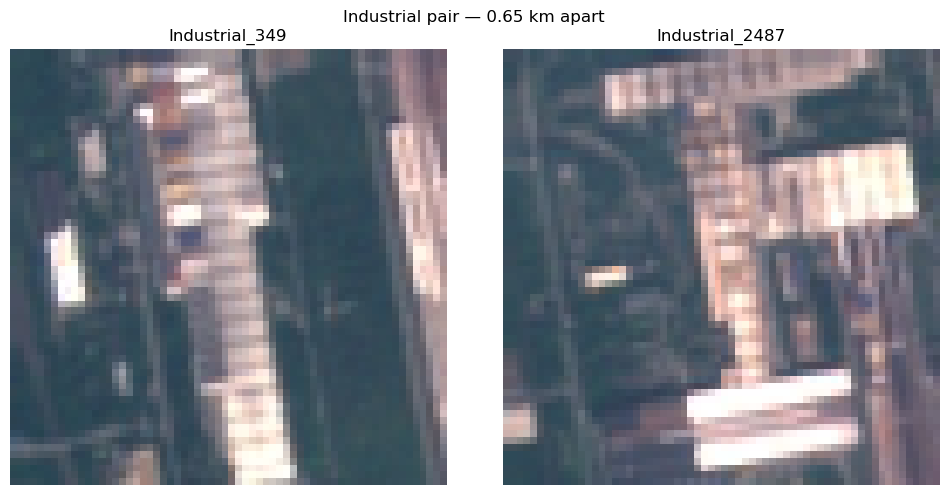

IDs: Industrial_349  |  Industrial_2487  |  distance = 0.65 km


('Industrial_349', 'Industrial_2487', 0.6499061624458734)

In [ ]:

rgb_path = "/share/DEEPLEARNING/carvalhj/EuroSAT_RGB/"
ms_path = "/share/DEEPLEARNING/carvalhj/EuroSAT_MS/"

#  already have the cache; just pass ms_path, rgb_path  use elsewhere
id1, id2, d = pick_two_close_industrial(ms_path, rgb_path, max_km=5.0, min_km=0.2)
print(id1, id2, d)

# …or actually see them
show_industrial_pair(ms_path, rgb_path, max_km=5.0, min_km=0.2)


In [4]:
def show_industrial_pair_separately(
    ms_path: str,
    rgb_path: str,
    max_km: float = 5.0,
    min_km: float = 0.0,
    seed: int = 42,
):
    id1, id2, dist_km = pick_two_close_industrial(
        ms_path=ms_path, rgb_path=rgb_path, max_km=max_km, min_km=min_km, seed=seed
    )

    df = extract_metadata(ms_path, rgb_path, use_cache=True)
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)

    def filepath_for_id(df_class, file_id):
        return os.path.join(
            rgb_path,
            df_class[df_class["filepath"].str.contains(file_id)].iloc[0]["filepath"],
        )

    p1 = filepath_for_id(dfi, id1)
    p2 = filepath_for_id(dfi, id2)

    from IPython.display import display
    img1 = Image.open(p1)
    img2 = Image.open(p2)

    print(f"Image 1: {id1}  ({p1})")
    display(img1)

    print(f"Image 2: {id2}  ({p2})")
    display(img2)

    print(f"Distance: {dist_km:.2f} km")
    return id1, id2, dist_km, p1, p2


Image 1: Industrial_349  (/share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_349.jpg)


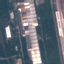

Image 2: Industrial_2487  (/share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_2487.jpg)


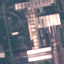

Distance: 0.65 km


In [5]:
id1, id2, d, p1, p2 = show_industrial_pair_separately(ms_path, rgb_path, max_km=5.0, min_km=0.2)


In [6]:
! pip install reverse_geocoder

In [7]:
import reverse_geocoder as rg
from IPython.display import display

def show_industrial_pair_with_geo(
    ms_path: str,
    rgb_path: str,
    max_km: float = 5.0,
    min_km: float = 0.0,
    seed: int = 42,
):
    # Find two Industrial images
    id1, id2, dist_km = pick_two_close_industrial(
        ms_path=ms_path, rgb_path=rgb_path,
        max_km=max_km, min_km=min_km, seed=seed
    )

    # Load cached metadata
    df = extract_metadata(ms_path, rgb_path, use_cache=True)
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)

    # Helper to get row from id
    def row_for_id(file_id):
        return dfi[dfi["filepath"].str.contains(file_id)].iloc[0]

    row1 = row_for_id(id1)
    row2 = row_for_id(id2)

    lat1, lon1 = row1["latitude"], row1["longitude"]
    lat2, lon2 = row2["latitude"], row2["longitude"]

    # Reverse geocode to country
    country1 = rg.search((lat1, lon1))[0]["cc"]
    country2 = rg.search((lat2, lon2))[0]["cc"]

    # File paths
    p1 = os.path.join(rgb_path, row1["filepath"])
    p2 = os.path.join(rgb_path, row2["filepath"])

    # Show images separately
    img1 = Image.open(p1)
    img2 = Image.open(p2)

    print(f"Image 1: {id1}")
    print(f"   lat/lon: {lat1:.4f}, {lon1:.4f}")
    print(f"   country: {country1}")
    print(f"   path: {p1}")
    display(img1)

    print(f"\nImage 2: {id2}")
    print(f"   lat/lon: {lat2:.4f}, {lon2:.4f}")
    print(f"   country: {country2}")
    print(f"   path: {p2}")
    display(img2)

    print(f"\nDistance between images: {dist_km:.2f} km")

    return {
        "id1": id1, "lat1": lat1, "lon1": lon1, "country1": country1, "path1": p1,
        "id2": id2, "lat2": lat2, "lon2": lon2, "country2": country2, "path2": p2,
        "distance_km": dist_km
    }


Loading formatted geocoded file...


Image 1: Industrial_349
   lat/lon: 50.3323, 19.2718
   country: PL
   path: /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_349.jpg


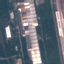


Image 2: Industrial_2487
   lat/lon: 50.3382, 19.2716
   country: PL
   path: /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_2487.jpg


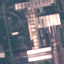


Distance between images: 0.65 km


In [8]:
info = show_industrial_pair_with_geo(ms_path, rgb_path, max_km=5.0, min_km=0.2)


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display

# --- helpers for country name (ISO2 -> full name) ---
def iso2_to_country_name(iso2: str) -> str:
    """Return full country name from ISO-3166 alpha-2 code. Falls back to the code itself."""
    if not iso2:
        return "Unknown"
    iso2 = iso2.upper()
    try:
        import pycountry  # pip install pycountry
        country = pycountry.countries.get(alpha_2=iso2)
        return country.name if country else iso2
    except Exception:
        # Fallback: try a small static dict to cover most common hits
        COMMON = {
            "US": "United States", "GB": "United Kingdom", "DE": "Germany",
            "FR": "France", "ES": "Spain", "IT": "Italy", "BR": "Brazil",
            "CA": "Canada", "CN": "China", "IN": "India", "RU": "Russia",
            "AU": "Australia", "MX": "Mexico"
        }
        return COMMON.get(iso2, iso2)

# --- reverse geocoding (offline) ---
def latlon_to_country_name(lat: float, lon: float) -> str:
    """Offline reverse geocode to country name using reverse_geocoder."""
    import reverse_geocoder as rg  # pip install reverse_geocoder
    cc = rg.search((lat, lon))[0]["cc"]  # ISO2 code
    return iso2_to_country_name(cc)

# --- plotting: globe/world map with points ---
def plot_points_on_world(latlon_list, labels=None, outfile="industrial_pair_map.png"):
    """
    latlon_list: [(lat1, lon1), (lat2, lon2), ...]
    labels: optional list of text labels
    Saves and displays a world map with points. Uses cartopy if available; else falls back.
    """
    try:
        import matplotlib.pyplot as plt
        import cartopy.crs as ccrs  # pip install cartopy
        import cartopy.feature as cfeature
        fig = plt.figure(figsize=(10, 6))
        ax = plt.axes(projection=ccrs.Robinson())
        ax.add_feature(cfeature.LAND, zorder=0)
        ax.add_feature(cfeature.OCEAN, zorder=0)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.gridlines(draw_labels=False, linewidth=0.3)

        for i, (lat, lon) in enumerate(latlon_list):
            ax.plot(lon, lat, marker="o", markersize=6, transform=ccrs.PlateCarree())
            if labels and i < len(labels):
                ax.text(lon, lat, f" {labels[i]}", transform=ccrs.PlateCarree(), fontsize=8)

        plt.title("Industrial pair locations")
        plt.tight_layout()
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
        plt.show()
    except Exception:
        # Fallback without cartopy: simple equirectangular scatter
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlim(-180, 180); ax.set_ylim(-90, 90)
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        ax.set_title("Industrial pair locations (equirectangular)")

        for i, (lat, lon) in enumerate(latlon_list):
            ax.plot(lon, lat, "o", markersize=6)
            if labels and i < len(labels):
                ax.text(lon, lat, f" {labels[i]}", fontsize=8)

        ax.grid(True, linewidth=0.3)
        plt.tight_layout()
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
        plt.show()

    print(f"Map saved to: {outfile}")
    return outfile

def show_industrial_pair_with_geo_and_plot(
    ms_path: str,
    rgb_path: str,
    max_km: float = 5.0,
    min_km: float = 0.0,
    seed: int = 42,
    save_images_dir: str = "industrial_pair_outputs",
):
    """
    - Picks two 'Industrial' samples within [min_km, max_km] km (uses  pickle cache).
    - Displays each image separately (so can right-click/save).
    - Prints full country names + lat/lon.
    - Saves a world map with both points to PNG.
    - Also copies the two images to save_images_dir for easy download.
    """
    os.makedirs(save_images_dir, exist_ok=True)

    # 1) pick pair
    id1, id2, dist_km = pick_two_close_industrial(
        ms_path=ms_path, rgb_path=rgb_path, max_km=max_km, min_km=min_km, seed=seed
    )

    # 2) fetch rows & paths
    df = extract_metadata(ms_path, rgb_path, use_cache=True)
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)

    def row_for_id(file_id):
        return dfi[dfi["filepath"].str.contains(file_id)].iloc[0]

    r1, r2 = row_for_id(id1), row_for_id(id2)
    p1 = os.path.join(rgb_path, r1["filepath"])
    p2 = os.path.join(rgb_path, r2["filepath"])

    lat1, lon1 = float(r1["latitude"]), float(r1["longitude"])
    lat2, lon2 = float(r2["latitude"]), float(r2["longitude"])

    # 3) country names (full)
    ctry1 = latlon_to_country_name(lat1, lon1)
    ctry2 = latlon_to_country_name(lat2, lon2)

    # 4) show each image separately + save copies
    img1 = Image.open(p1)
    img2 = Image.open(p2)

    # Display for quick download (right-click in notebook)
    print(f"Image 1: {id1}")
    print(f"  Country: {ctry1}")
    print(f"  Lat/Lon: {lat1:.5f}, {lon1:.5f}")
    print(f"  Path:    {p1}")
    display(img1)

    print(f"\nImage 2: {id2}")
    print(f"  Country: {ctry2}")
    print(f"  Lat/Lon: {lat2:.5f}, {lon2:.5f}")
    print(f"  Path:    {p2}")
    display(img2)

    # Save copies to an output folder
    out1 = os.path.join(save_images_dir, f"{id1}.jpg")
    out2 = os.path.join(save_images_dir, f"{id2}.jpg")
    img1.save(out1)
    img2.save(out2)
    print(f"\nSaved image copies to:\n  {out1}\n  {out2}")

    # 5) world map plot with both points
    map_file = os.path.join(save_images_dir, "industrial_pair_map.png")
    plot_points_on_world([(lat1, lon1), (lat2, lon2)], labels=[id1, id2], outfile=map_file)

    print(f"\nDistance between images: {dist_km:.2f} km")
    return {
        "id1": id1, "lat1": lat1, "lon1": lon1, "country1": ctry1, "path1": p1, "saved1": out1,
        "id2": id2, "lat2": lat2, "lon2": lon2, "country2": ctry2, "path2": p2, "saved2": out2,
        "distance_km": dist_km, "map_file": map_file
    }


Image 1: Industrial_1802
  Country: Bulgaria
  Lat/Lon: 42.60806, 23.08273
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1802.jpg


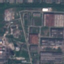


Image 2: Industrial_1358
  Country: Bulgaria
  Lat/Lon: 42.60099, 23.08215
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1358.jpg


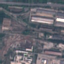


Saved image copies to:
  industrial_pair_outputs/Industrial_1802.jpg
  industrial_pair_outputs/Industrial_1358.jpg


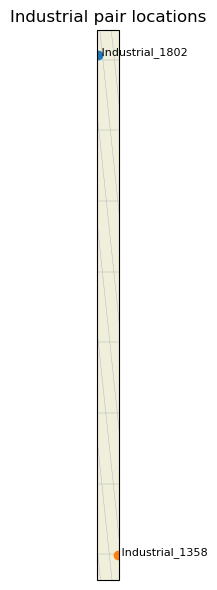

Map saved to: industrial_pair_outputs/industrial_pair_map.png

Distance between images: 0.79 km


In [10]:
info = show_industrial_pair_with_geo_and_plot(
    ms_path, rgb_path, max_km=5.0, min_km=0.2, seed=123, save_images_dir="industrial_pair_outputs"
)


In [11]:
!pip install reverse_geocoder pycountry
# optional but nicer world map:
!pip install cartopy


In [ ]:
import os, math, pandas as pd

EARTH_RADIUS_KM = 6371.0088

def _hav_km(lat1, lon1, lat2, lon2):
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2 * EARTH_RADIUS_KM * math.asin(math.sqrt(a))

In [ ]:
import os
import numpy as np
from PIL import Image
from IPython.display import display

EARTH_RADIUS_KM = 6371.0088

def _haversine_vec_single_to_many(anchor_deg, many_deg):
    a = np.deg2rad(np.asarray(anchor_deg, dtype=float))
    b = np.deg2rad(np.asarray(many_deg, dtype=float))
    dphi = b[:,0] - a[0]
    dlmb = b[:,1] - a[1]
    s = np.sin(dphi/2)**2 + np.cos(a[0]) * np.cos(b[:,0]) * np.sin(dlmb/2)**2
    return 2 * EARTH_RADIUS_KM * np.arcsin(np.sqrt(s))  # [N]

def _stem(path):
    return os.path.splitext(os.path.basename(path))[0]

def _row_by_id(df, stem_id):
    idx = df["filepath"].apply(lambda p: _stem(p)) == stem_id
    if not np.any(idx):
        raise ValueError(f"Could not find item with id '{stem_id}' in dataframe.")
    return df[idx].iloc[0]

def pick_one_different_class_farther(
    ms_path: str,
    rgb_path: str,
    id1: str,
    id2: str,
    exclude_class: str = "Industrial",
    min_km_away: float = 30.0,
    max_km_away: float = 2000.0,   # set None to disable upper bound
    choose: str = "closest_over_min",  # or "random"
    seed: int = 0,
):
    """
    Pick one sample with class != exclude_class whose distance to BOTH anchors (id1,id2)
    is >= min_km_away (and <= max_km_away if given).
    Returns: dict with keys: id, class, lat, lon, country, path, d_to_id1, d_to_id2, dmin
    """
    rng = np.random.default_rng(seed)
    df = extract_metadata(ms_path, rgb_path, use_cache=True).reset_index(drop=True)

    r1 = _row_by_id(df, id1)
    r2 = _row_by_id(df, id2)
    a1 = (float(r1["latitude"]), float(r1["longitude"]))
    a2 = (float(r2["latitude"]), float(r2["longitude"]))

    cand = df[df["class"] != exclude_class].reset_index(drop=True)
    if cand.empty:
        raise RuntimeError(f"No candidates found outside class '{exclude_class}'.")

    coords = cand[["latitude", "longitude"]].to_numpy(dtype=float)
    d1 = _haversine_vec_single_to_many(a1, coords)
    d2 = _haversine_vec_single_to_many(a2, coords)
    dmin = np.minimum(d1, d2)

    ok = dmin >= min_km_away
    if max_km_away is not None:
        ok &= dmin <= max_km_away

    if not np.any(ok):
        raise RuntimeError(
            f"No sample from a different class is at least {min_km_away} km away "
            f"(and <= {max_km_away} km) from BOTH anchors."
        )

    idxs = np.where(ok)[0]
    if choose == "closest_over_min":
        j = idxs[np.argmin(dmin[idxs])]
    else:
        j = int(rng.choice(idxs))

    row = cand.iloc[j]
    lat, lon = float(row["latitude"]), float(row["longitude"])
    cc = latlon_to_country_name(lat, lon)
    return {
        "id": _stem(row["filepath"]),
        "class": row["class"],
        "lat": lat, "lon": lon,
        "country": cc,
        "path": os.path.join(rgb_path, row["filepath"]),
        "d_to_id1": float(d1[j]),
        "d_to_id2": float(d2[j]),
        "dmin": float(dmin[j]),
    }

def show_industrial_pair_plus_third(
    ms_path: str,
    rgb_path: str,
    max_km_pair: float = 5.0,
    min_km_pair: float = 0.0,
    min_km_third: float = 30.0,
    max_km_third: float = 2000.0,
    seed_pair: int = 42,
    seed_third: int = 0,
    save_dir: str = "industrial_pair_outputs",
):
    """
    1) Picks two close Industrial images.
    2) Picks one image from a DIFFERENT class at least min_km_third away from BOTH.
    3) Prints metadata, shows images separately, saves copies, and writes global+zoom maps.
    """
    os.makedirs(save_dir, exist_ok=True)

    id1, id2, dist12 = pick_two_close_industrial(
        ms_path=ms_path, rgb_path=rgb_path,
        max_km=max_km_pair, min_km=min_km_pair, seed=seed_pair
    )
    df = extract_metadata(ms_path, rgb_path, use_cache=True)
    dfi = df[df["class"] == "Industrial"].reset_index(drop=True)
    r1 = _row_by_id(dfi, id1)
    r2 = _row_by_id(dfi, id2)

    p1 = os.path.join(rgb_path, r1["filepath"])
    p2 = os.path.join(rgb_path, r2["filepath"])
    lat1, lon1 = float(r1["latitude"]), float(r1["longitude"])
    lat2, lon2 = float(r2["latitude"]), float(r2["longitude"])
    ctry1 = latlon_to_country_name(lat1, lon1)
    ctry2 = latlon_to_country_name(lat2, lon2)

    img1 = Image.open(p1); img2 = Image.open(p2)

    print(f"Industrial 1: {id1}")
    print(f"  Country: {ctry1}")
    print(f"  Lat/Lon: {lat1:.5f}, {lon1:.5f}")
    print(f"  Path:    {p1}")
    display(img1)

    print(f"\nIndustrial 2: {id2}")
    print(f"  Country: {ctry2}")
    print(f"  Lat/Lon: {lat2:.5f}, {lon2:.5f}")
    print(f"  Path:    {p2}")
    display(img2)

    out1 = os.path.join(save_dir, f"{id1}.jpg")
    out2 = os.path.join(save_dir, f"{id2}.jpg")
    img1.save(out1); img2.save(out2)

    third = pick_one_different_class_farther(
        ms_path, rgb_path, id1, id2,
        exclude_class="Industrial",
        min_km_away=min_km_third,
        max_km_away=max_km_third,
        choose="closest_over_min",
        seed=seed_third,
    )
    img3 = Image.open(third["path"])
    print(f"\nThird (different class): {third['id']}")
    print(f"  Class:   {third['class']}")
    print(f"  Country: {third['country']}")
    print(f"  Lat/Lon: {third['lat']:.5f}, {third['lon']:.5f}")
    print(f"  Dist to {id1}: {third['d_to_id1']:.2f} km")
    print(f"  Dist to {id2}: {third['d_to_id2']:.2f} km")
    print(f"  Path:    {third['path']}")
    display(img3)

    out3 = os.path.join(save_dir, f"{third['id']}.jpg")
    img3.save(out3)
    print(f"\nSaved image copies:\n  {out1}\n  {out2}\n  {out3}")


    try:
        global_map, zoom_map = plot_points_better(
            [(lat1, lon1), (lat2, lon2), (third["lat"], third["lon"])],
            labels=[id1, id2, f"{third['id']} ({third['class']})"],
            out_dir=save_dir,
            basename="industrial_pair_plus_third",
        )
        print(f"\nSaved maps:\n  {global_map}\n  {zoom_map}")
    except NameError:

        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlim(-180,180); ax.set_ylim(-90,90); ax.set_aspect("equal","box")
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude"); ax.grid(True, lw=0.3, alpha=0.5)
        pts = [(lat1,lon1,id1),(lat2,lon2,id2),(third["lat"],third["lon"],third["id"]+" ("+third["class"]+")")]
        for la,lo,lb in pts:
            ax.plot(lo,la,"o",ms=6); ax.annotate(lb,(lo,la),xytext=(6,6),textcoords="offset points",fontsize=9)
        out = os.path.join(save_dir, "industrial_pair_plus_third_global.png")
        plt.title("Industrial pair + third (fallback)"); plt.savefig(out, dpi=220, bbox_inches="tight"); plt.close()
        print(f"\nSaved fallback map: {out}")
    
    def print_and_save_all_triplet_distances(id1, lat1, lon1, id2, lat2, lon2, id3, lat3, lon3, save_dir):
        d12 = _hav_km(lat1, lon1, lat2, lon2)
        d13 = _hav_km(lat1, lon1, lat3, lon3)
        d23 = _hav_km(lat2, lon2, lat3, lon3)

        print("\n=== Pairwise distances (km) ===")
        print(f"{id1} ↔ {id2}: {d12:.2f} km")  # Industrial 1 ↔ Industrial 2
        print(f"{id1} ↔ {id3}: {d13:.2f} km")
        print(f"{id2} ↔ {id3}: {d23:.2f} km")

        df = pd.DataFrame(
            [
                {"a": id1, "b": id2, "distance_km": round(d12, 3)},
                {"a": id1, "b": id3, "distance_km": round(d13, 3)},
                {"a": id2, "b": id3, "distance_km": round(d23, 3)},
            ]
        )
        os.makedirs(save_dir, exist_ok=True)
        out_csv = os.path.join(save_dir, "pairwise_distances_km.csv")
        df.to_csv(out_csv, index=False)
        print(f"Saved distances CSV → {out_csv}")
        return {"d12": d12, "d13": d13, "d23": d23, "csv": out_csv}

    print_and_save_all_triplet_distances(
        id1, lat1, lon1,
        id2, lat2, lon2,
        third["id"], third["lat"], third["lon"],
        save_dir
    )


    return {
        "pair": {
            "id1": id1, "country1": ctry1, "lat1": lat1, "lon1": lon1, "path1": p1, "saved1": out1,
            "id2": id2, "country2": ctry2, "lat2": lat2, "lon2": lon2, "path2": p2, "saved2": out2,
            "distance_km": float(dist12)
        },
        "third": third,
        "out_dir": save_dir
    }




Industrial 1: Industrial_1802
  Country: Bulgaria
  Lat/Lon: 42.60806, 23.08273
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1802.jpg


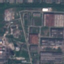


Industrial 2: Industrial_1358
  Country: Bulgaria
  Lat/Lon: 42.60099, 23.08215
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1358.jpg


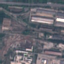


Third (different class): Pasture_1074
  Class:   Pasture
  Country: Bulgaria
  Lat/Lon: 43.06342, 23.20610
  Dist to Industrial_1802: 51.62 km
  Dist to Industrial_1358: 52.40 km
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Pasture/Pasture_1074.jpg


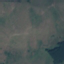


Saved image copies:
  industrial_pair_outputs/Industrial_1802.jpg
  industrial_pair_outputs/Industrial_1358.jpg
  industrial_pair_outputs/Pasture_1074.jpg

Saved fallback map: industrial_pair_outputs/industrial_pair_plus_third_global.png

=== Pairwise distances (km) ===
Industrial_1802 ↔ Industrial_1358: 0.79 km
Industrial_1802 ↔ Pasture_1074: 51.62 km
Industrial_1358 ↔ Pasture_1074: 52.40 km
Saved distances CSV → industrial_pair_outputs/pairwise_distances_km.csv


In [14]:
res = show_industrial_pair_plus_third(
    ms_path, rgb_path,
    max_km_pair=5.0, min_km_pair=0.2,     # close Industrial pair
    min_km_third=50.0, max_km_third=1500, # "a bit away" from BOTH
    seed_pair=123, seed_third=0,
    save_dir="industrial_pair_outputs"
)


In [ ]:
import math
import pandas as pd

EARTH_RADIUS_KM = 6371.0088

def _haversine_km_pts(lat1, lon1, lat2, lon2):
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2 * EARTH_RADIUS_KM * math.asin(math.sqrt(a))

def _print_and_save_distances(id1, lat1, lon1, id2, lat2, lon2, id3, lat3, lon3, save_dir):
    d12 = _haversine_km_pts(lat1, lon1, lat2, lon2)
    d13 = _haversine_km_pts(lat1, lon1, lat3, lon3)
    d23 = _haversine_km_pts(lat2, lon2, lat3, lon3)

    print("\n=== Pairwise distances (km) ===")
    print(f"{id1} ↔ {id2}: {d12:.2f} km")
    print(f"{id1} ↔ {id3}: {d13:.2f} km")
    print(f"{id2} ↔ {id3}: {d23:.2f} km")

    # Save CSV for easy download
    df = pd.DataFrame(
        [
            {"a": id1, "b": id2, "distance_km": round(d12, 3)},
            {"a": id1, "b": id3, "distance_km": round(d13, 3)},
            {"a": id2, "b": id3, "distance_km": round(d23, 3)},
        ]
    )
    csv_path = os.path.join(save_dir, "pairwise_distances_km.csv")
    df.to_csv(csv_path, index=False)
    print(f"Distances CSV saved to: {csv_path}")


Industrial 1: Industrial_1802
  Country: Bulgaria
  Lat/Lon: 42.60806, 23.08273
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1802.jpg


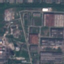


Industrial 2: Industrial_1358
  Country: Bulgaria
  Lat/Lon: 42.60099, 23.08215
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Industrial/Industrial_1358.jpg


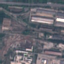


Third (different class): Pasture_1074
  Class:   Pasture
  Country: Bulgaria
  Lat/Lon: 43.06342, 23.20610
  Dist to Industrial_1802: 51.62 km
  Dist to Industrial_1358: 52.40 km
  Path:    /share/DEEPLEARNING/carvalhj/EuroSAT_RGB/Pasture/Pasture_1074.jpg


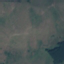


Saved image copies:
  industrial_pair_outputs/Industrial_1802.jpg
  industrial_pair_outputs/Industrial_1358.jpg
  industrial_pair_outputs/Pasture_1074.jpg

Saved fallback map: industrial_pair_outputs/industrial_pair_plus_third_global.png

=== Pairwise distances (km) ===
Industrial_1802 ↔ Industrial_1358: 0.79 km
Industrial_1802 ↔ Pasture_1074: 51.62 km
Industrial_1358 ↔ Pasture_1074: 52.40 km
Saved distances CSV → industrial_pair_outputs/pairwise_distances_km.csv


In [16]:
res = show_industrial_pair_plus_third(
    ms_path, rgb_path,
    max_km_pair=5.0, min_km_pair=0.2,
    min_km_third=50.0, max_km_third=1500.0,
    seed_pair=123, seed_third=0,
    save_dir="industrial_pair_outputs"
)


In [17]:
from simclr.data.transforms import  get_transforms


In [ ]:
import os
import torch
from PIL import Image
from IPython.display import display
from torchvision import transforms

# --- helpers ---
def _ensure_list(x):
    return list(x) if isinstance(x, (list, tuple)) else [x]

def _denorm_to_pil(tensor, mean, std):
    """
    tensor: CxHxW, normalized
    mean/std: sequences length 3
    -> PIL Image
    """
    if not torch.is_tensor(tensor):
        raise TypeError("Expected a torch.Tensor")
    m = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device)[:, None, None]
    s = torch.tensor(std,  dtype=tensor.dtype, device=tensor.device)[:, None, None]
    img = tensor * s + m
    img = img.clamp(0, 1).cpu()
    to_pil = transforms.ToPILImage()
    return to_pil(img)

def _augment_twice(pil_img, augment_transform):
    # create two independent views
    x1 = augment_transform(pil_img)
    x2 = augment_transform(pil_img)
    return x1, x2  # tensors (normalized)

def _save_show(img_pil, out_path, title=None):
    img_pil.save(out_path)
    print(f"saved: {out_path}")
    if title:
        print(title)
    display(img_pil)

def augment_two_per_image(
    image_paths,          # list[str] or tuple[str,...]
    image_ids=None,       # optional list of ids for filenames/titles
    mean=(0.485,0.456,0.406),
    std=(0.229,0.224,0.225),
    out_dir="industrial_pair_outputs/aug",
    seed=None
):
    """
    For each path in image_paths, generate 2 augmentations with augment_transform,
    denorm for visualization, display each separately, and save PNGs.
    Returns a dict of saved file paths.
    """
    os.makedirs(out_dir, exist_ok=True)
    if seed is not None:
        torch.manual_seed(seed)

    # get transforms (we only need augment_transform)
    eval_tf, augment_transform = get_transforms(mean, std)

    image_paths = _ensure_list(image_paths)
    if image_ids is None:
        image_ids = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]

    saved = {}
    for p, img_id in zip(image_paths, image_ids):
        pil_img = Image.open(p).convert("RGB")
        t1, t2 = _augment_twice(pil_img, augment_transform)

        # denorm for viewing/saving
        a1 = _denorm_to_pil(t1, mean, std)
        a2 = _denorm_to_pil(t2, mean, std)

        out1 = os.path.join(out_dir, f"{img_id}_aug1.png")
        out2 = os.path.join(out_dir, f"{img_id}_aug2.png")

        print(f"\n=== {img_id} ===")
        _save_show(a1, out1, title=f"{img_id} — aug1")
        _save_show(a2, out2, title=f"{img_id} — aug2")

        saved[img_id] = {"aug1": out1, "aug2": out2}

    return saved



=== Industrial_1802 ===
saved: industrial_pair_outputs/aug/Industrial_1802_aug1.png
Industrial_1802 — aug1


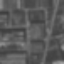

saved: industrial_pair_outputs/aug/Industrial_1802_aug2.png
Industrial_1802 — aug2


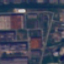


=== Industrial_1358 ===
saved: industrial_pair_outputs/aug/Industrial_1358_aug1.png
Industrial_1358 — aug1


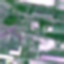

saved: industrial_pair_outputs/aug/Industrial_1358_aug2.png
Industrial_1358 — aug2


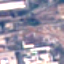


=== Pasture_1074 ===
saved: industrial_pair_outputs/aug/Pasture_1074_aug1.png
Pasture_1074 — aug1


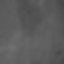

saved: industrial_pair_outputs/aug/Pasture_1074_aug2.png
Pasture_1074 — aug2


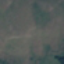

{'Industrial_1802': {'aug1': 'industrial_pair_outputs/aug/Industrial_1802_aug1.png', 'aug2': 'industrial_pair_outputs/aug/Industrial_1802_aug2.png'}, 'Industrial_1358': {'aug1': 'industrial_pair_outputs/aug/Industrial_1358_aug1.png', 'aug2': 'industrial_pair_outputs/aug/Industrial_1358_aug2.png'}, 'Pasture_1074': {'aug1': 'industrial_pair_outputs/aug/Pasture_1074_aug1.png', 'aug2': 'industrial_pair_outputs/aug/Pasture_1074_aug2.png'}}


In [ ]:

from simclr.config import CONFIG

paths = [
    res["pair"]["path1"],
    res["pair"]["path2"],
    res["third"]["path"],
]
ids = [
    res["pair"]["id1"] if "id1" in res["pair"] else os.path.splitext(os.path.basename(res["pair"]["path1"]))[0],
    res["pair"]["id2"] if "id2" in res["pair"] else os.path.splitext(os.path.basename(res["pair"]["path2"]))[0],
    res["third"]["id"],
]

saved = augment_two_per_image(
    image_paths=paths,
    image_ids=ids,
    mean=CONFIG["MEAN"], std=CONFIG["STD"],
    out_dir="industrial_pair_outputs/aug",
    seed=123  # optional, for reproducibility
)
print(saved)
